# SSD Evaluation

In [8]:
from keras import backend as K
from keras.models import load_model
from keras.optimizers import Adam
from scipy.misc import imread
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd7 import build_model
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization
from data_generator.object_detection_2d_data_generator import DataGenerator
from eval_utils.average_precision_evaluator import Evaluator

%matplotlib inline

In [9]:
img_height = 300
img_width = 480
img_channels = 3
intensity_mean = None
intensity_range = None
n_classes = 5
scales = [0.08, 0.16, 0.32, 0.64, 0.96]
aspect_ratios = [0.5, 1.0, 2.0]
two_boxes_for_ar1 = True
steps = None
offsets = None
clip_boxes = False
variances = [1.0, 1.0, 1.0, 1.0]
normalize_coords = True

## Load a trained SSD

Build the model and load trained weights into it

In [10]:
K.clear_session()

model = build_model(image_size=(img_height, img_width, img_channels),
                    n_classes=n_classes,
                    mode='inference',
                    l2_regularization=0.0007,
                    scales=scales,
                    aspect_ratios_global=aspect_ratios,
                    aspect_ratios_per_layer=None,
                    two_boxes_for_ar1=two_boxes_for_ar1,
                    steps=steps,
                    offsets=offsets,
                    clip_boxes=clip_boxes,
                    variances=variances,
                    normalize_coords=normalize_coords,
                    subtract_mean=intensity_mean,
                    divide_by_stddev=intensity_range)

model.load_weights('C:/Users/Ignatios/Documents/ssd_keras/model_weights/custom/ssd7_epoch-19_loss-1.4077_val_loss-1.8736.h5', by_name=True)

adam = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

Create a data generator for the evaluation dataset

Instantiate a `DataGenerator` that will serve the evaluation dataset during the prediction phase.

In [11]:
dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)

images_dir = 'C:/Users/Ignatios/Documents/ssd_keras/test_dataset/Evaluation_photos/'
val_labels_filename = 'C:/Users/Ignatios/Documents/ssd_keras/test_dataset/labels.csv'

dataset.parse_csv(images_dir=images_dir,
                      labels_filename=val_labels_filename,
                      input_format=['image_name', 'class_id', 'xmin', 'ymin', 'xmax', 'ymax'],
                      include_classes='all')

val_dataset_size   = dataset.get_dataset_size()

print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Number of images in the validation dataset:	    73


## Run the evaluation

In [12]:
evaluator = Evaluator(model=model,
                      n_classes=n_classes,
                      data_generator=dataset,
                      model_mode='inference')

results = evaluator(img_height=img_height,
                    img_width=img_width,
                    batch_size=8,
                    data_generator_mode='resize',
                    round_confidences=False,
                    matching_iou_threshold=0.5,
                    border_pixels='include',
                    sorting_algorithm='quicksort',
                    average_precision_mode='sample',
                    num_recall_points=11,
                    ignore_neutral_boxes=True,
                    return_precisions=True,
                    return_recalls=True,
                    return_average_precisions=True,
                    verbose=True)

mean_average_precision, average_precisions, precisions, recalls = results

Number of images in the evaluation dataset: 73

Matching predictions to ground truth, class 5/5.: 100%|██████████| 1238/1238 [00:00<00:00, 13764.28it/s]
Computing precisions and recalls, class 1/5
Computing precisions and recalls, class 2/5
Computing precisions and recalls, class 3/5
Computing precisions and recalls, class 4/5
Computing precisions and recalls, class 5/5
Computing average precision, class 1/5
Computing average precision, class 2/5
Computing average precision, class 3/5
Computing average precision, class 4/5
Computing average precision, class 5/5


## Visualize the results

In [13]:
classes = ['background', 'BB8', 'R2D2', 'Yoda', 'Chewbacca', 'Stormtrooper']

for i in range(1, len(average_precisions)):
    print("{:<14}{:<6}{}".format(classes[i], 'AP', round(average_precisions[i], 3)))
print()
print("{:<14}{:<6}{}".format('','mAP', round(mean_average_precision, 3)))

BB8           AP    0.893
R2D2          AP    0.973
Yoda          AP    0.823
Chewbacca     AP    0.826
Stormtrooper  AP    0.617

              mAP   0.826


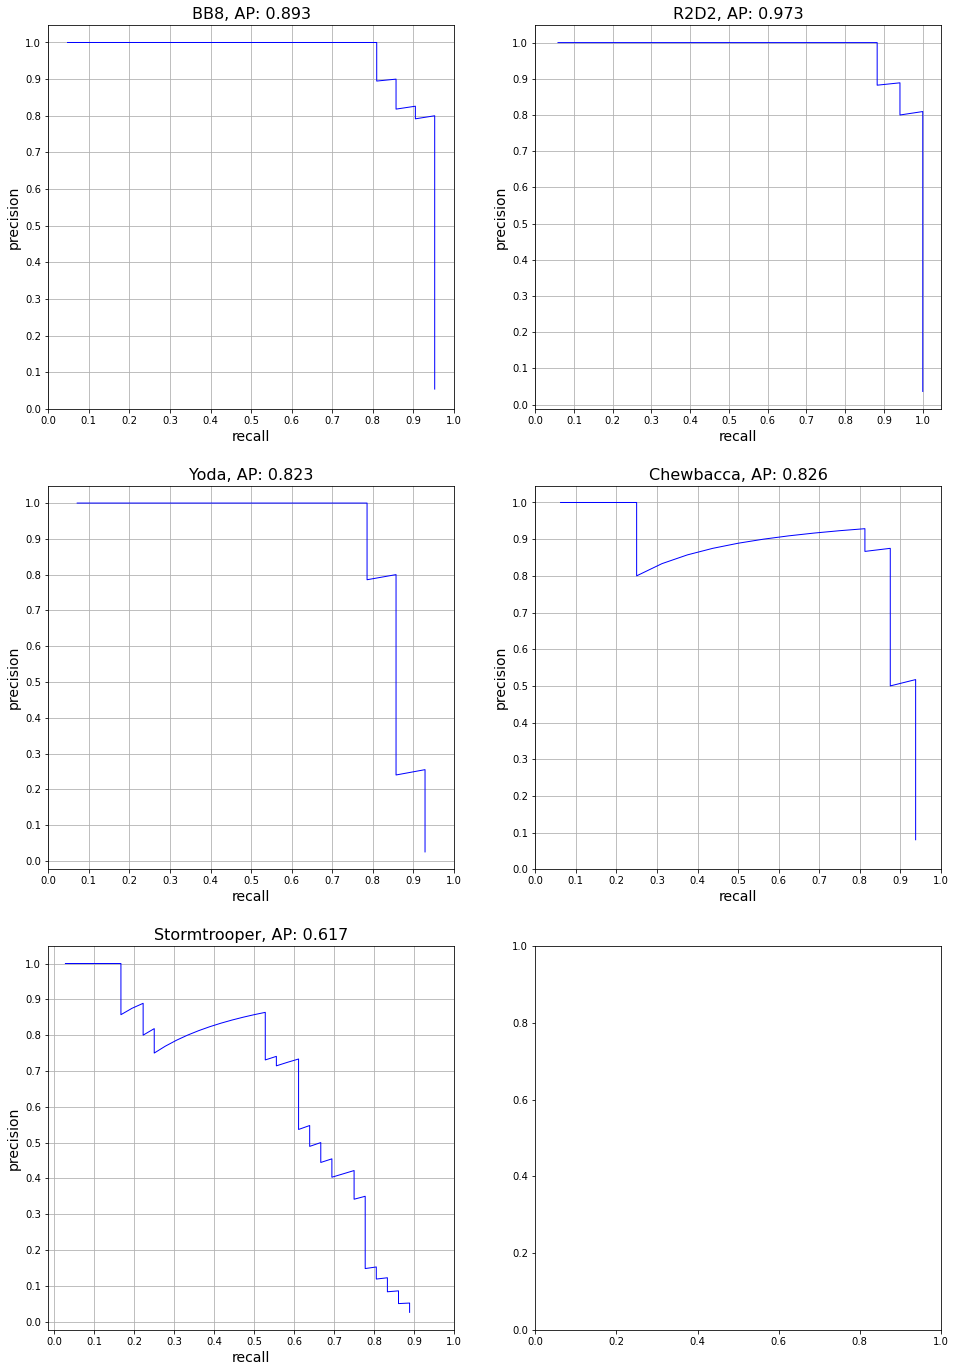

In [14]:
m = max((n_classes + 1) // 2, 2)
n = 2

fig, cells = plt.subplots(m, n, figsize=(n*8,m*8))
for i in range(m):
    for j in range(n):
        if n*i+j+1 > n_classes: break
        cells[i, j].plot(recalls[n*i+j+1], precisions[n*i+j+1], color='blue', linewidth=1.0)
        cells[i, j].set_xlabel('recall', fontsize=14)
        cells[i, j].set_ylabel('precision', fontsize=14)
        cells[i, j].grid(True)
        cells[i, j].set_xticks(np.linspace(0,1,11))
        cells[i, j].set_yticks(np.linspace(0,1,11))
        cells[i, j].set_title("{}, AP: {:.3f}".format(classes[n*i+j+1], average_precisions[n*i+j+1]), fontsize=16)